In [114]:
import configparser
import os
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.functions import udf, col, lit
from pyspark.sql.types import MapType, StringType, FloatType
from pyspark.sql import DataFrame, Window
from collections import OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
config = configparser.ConfigParser()
config.read("capstone.cfg")

os.chdir(config["PATH"]["project"])
project_path = config["PATH"]["project"]


In [4]:
def create_spark_session():
    spark = SparkSession \
        .builder \
        .appName("covid_DB") \
        .getOrCreate()
    
    return spark

In [5]:
spark = create_spark_session()

In [6]:
df_covid = spark.read.option("header", True).csv(os.path.join(project_path, "DATA","COVID", "us-counties.csv"))

In [7]:
df_covid.printSchema()

root
 |-- date: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- fips: string (nullable = true)
 |-- cases: string (nullable = true)
 |-- deaths: string (nullable = true)



In [8]:
df_covid.show()

+----------+-----------+----------+-----+-----+------+
|      date|     county|     state| fips|cases|deaths|
+----------+-----------+----------+-----+-----+------+
|2020-01-21|  Snohomish|Washington|53061|    1|     0|
|2020-01-22|  Snohomish|Washington|53061|    1|     0|
|2020-01-23|  Snohomish|Washington|53061|    1|     0|
|2020-01-24|       Cook|  Illinois|17031|    1|     0|
|2020-01-24|  Snohomish|Washington|53061|    1|     0|
|2020-01-25|     Orange|California|06059|    1|     0|
|2020-01-25|       Cook|  Illinois|17031|    1|     0|
|2020-01-25|  Snohomish|Washington|53061|    1|     0|
|2020-01-26|   Maricopa|   Arizona|04013|    1|     0|
|2020-01-26|Los Angeles|California|06037|    1|     0|
|2020-01-26|     Orange|California|06059|    1|     0|
|2020-01-26|       Cook|  Illinois|17031|    1|     0|
|2020-01-26|  Snohomish|Washington|53061|    1|     0|
|2020-01-27|   Maricopa|   Arizona|04013|    1|     0|
|2020-01-27|Los Angeles|California|06037|    1|     0|
|2020-01-2

In [9]:
df_covid.count()

1170376

In [10]:
df_covid.where(col("fips").isNull()).count()

10721

In [11]:
map_fips_stations = spark.read.parquet( os.path.join(project_path, "OUT_DATA/", "stations_per_fips"))

In [12]:
map_fips_stations.printSchema()

root
 |-- location_id: long (nullable = true)
 |-- fips: string (nullable = true)
 |-- county: string (nullable = true)
 |-- fips_state: string (nullable = true)
 |-- station_id: string (nullable = true)
 |-- station_name: string (nullable = true)
 |-- station_state: string (nullable = true)
 |-- angle: double (nullable = true)
 |-- distance: double (nullable = true)
 |-- measured: string (nullable = true)



In [13]:
nyt_locations = df_covid.select("fips", "county", "state").distinct()

In [14]:
nyt_locations.count()

3274

In [15]:
map_locations = map_fips_stations.select("location_id", "fips", "county", "fips_state").distinct()
map_locations.count()

3272

In [16]:
nyt_locations.join(map_locations, 
            (nyt_locations.fips.eqNullSafe(map_locations.fips) ) &
            (nyt_locations.county.eqNullSafe(map_locations.county) )& 
            (nyt_locations.state.eqNullSafe( map_locations.fips_state) ) )\
            .count()

3272

In [17]:
nyt_locations.join(map_locations, 
            (nyt_locations.fips.eqNullSafe(map_locations.fips) ) &
            (nyt_locations.county.eqNullSafe(map_locations.county) )& 
            (nyt_locations.state.eqNullSafe( map_locations.fips_state) ) ,
            how = "left_anti")\
            .show()

+-----+--------------------+------+
| fips|              county| state|
+-----+--------------------+------+
|02997|Bristol Bay plus ...|Alaska|
|02998|Yakutat plus Hoon...|Alaska|
+-----+--------------------+------+



In [18]:
# filter out non matched locations and add location_id
df_covid_filter = df_covid.alias("covid").join( map_locations.alias("loc"),
            (df_covid.fips.eqNullSafe(map_fips_stations.fips) ) &
            (df_covid.county.eqNullSafe(map_fips_stations.county) ) & 
            (df_covid.state.eqNullSafe( map_fips_stations.fips_state) ) )\
       .select("date", "location_id", "covid.fips", "covid.county", "covid.state", "deaths", "cases")
                                             

In [19]:
# compute daily cases and daily deaths, from cumulated values
# first add a column with the lag value (i.e. the value from the previous day)
# then compute the difference btw current day and previous day values
w = Window.partitionBy("location_id").orderBy("date")
df_covid_daily = df_covid_filter\
    .withColumn("deaths_prev", F.lag("deaths", count = 1, default = 0).over(w) ) \
    .withColumn("cases_prev", F.lag("cases", count = 1, default = 0).over(w) )\
    .withColumn("daily_deaths", col("deaths") - col("deaths_prev"))\
    .withColumn("daily_cases", col("cases") - col("cases_prev"))

In [20]:
# check value of prev deaths for LA county
df_covid_daily.where( (col("fips") == "06037") & ( F.month(col("date")) == 12) ).show()

+----------+-----------+-----+-----------+----------+------+------+-----------+----------+------------+-----------+
|      date|location_id| fips|     county|     state|deaths| cases|deaths_prev|cases_prev|daily_deaths|daily_cases|
+----------+-----------+-----+-----------+----------+------+------+-----------+----------+------------+-----------+
|2020-12-01|17179869218|06037|Los Angeles|California|  7700|408515|       7655|    401034|        45.0|     7481.0|
|2020-12-02|17179869218|06037|Los Angeles|California|  7740|414304|       7700|    408515|        40.0|     5789.0|
|2020-12-03|17179869218|06037|Los Angeles|California|  7782|422000|       7740|    414304|        42.0|     7696.0|
|2020-12-04|17179869218|06037|Los Angeles|California|  7842|430713|       7782|    422000|        60.0|     8713.0|
|2020-12-05|17179869218|06037|Los Angeles|California|  7886|439538|       7842|    430713|        44.0|     8825.0|
|2020-12-06|17179869218|06037|Los Angeles|California|  7909|449982|     

In [21]:
# to smooth down anomalies due to data reporting (e.g. no data reported on weekends), compute cumulation over a week


In [22]:
# add a days column, counting days from 2019/01/01. Needed because the window function rangeBetween operates only on integers
df_covid_daily = df_covid_daily.withColumn("days", F.datediff( col("date") , F.to_date( lit("2019-01-01") )) )

In [23]:
df_covid_daily.where( (col("fips") == "06037") & ( F.month(col("date")) == 3)  & (F.year(col("date")) == 2020) ).show(40)

+----------+-----------+-----+-----------+----------+------+-----+-----------+----------+------------+-----------+----+
|      date|location_id| fips|     county|     state|deaths|cases|deaths_prev|cases_prev|daily_deaths|daily_cases|days|
+----------+-----------+-----+-----------+----------+------+-----+-----------+----------+------------+-----------+----+
|2020-03-01|17179869218|06037|Los Angeles|California|     0|    1|          0|         1|         0.0|        0.0| 425|
|2020-03-02|17179869218|06037|Los Angeles|California|     0|    1|          0|         1|         0.0|        0.0| 426|
|2020-03-03|17179869218|06037|Los Angeles|California|     0|    1|          0|         1|         0.0|        0.0| 427|
|2020-03-04|17179869218|06037|Los Angeles|California|     0|    7|          0|         1|         0.0|        6.0| 428|
|2020-03-05|17179869218|06037|Los Angeles|California|     0|   11|          0|         7|         0.0|        4.0| 429|
|2020-03-06|17179869218|06037|Los Angele

In [24]:
w = Window.partitionBy("location_id").orderBy("days").rangeBetween(-6,0)

In [25]:
df_covid_daily = df_covid_daily.withColumn("week_deaths", F.sum("daily_deaths").over(w) )\
        .withColumn("week_cases", F.sum("daily_cases").over(w) )

In [26]:
df_covid_daily.where( (col("fips") == "06037") & ( F.month(col("date")) == 3)  & (F.year(col("date")) == 2020) ).toPandas()

,date,location_id,fips,county,state,deaths,cases,deaths_prev,cases_prev,daily_deaths,daily_cases,days,week_deaths,week_cases
0,2020-03-01,17179869218,06037,Los Angeles,California,0,1,0,1,0.0,0.0,425,0.0,0.0
1,2020-03-02,17179869218,06037,Los Angeles,California,0,1,0,1,0.0,0.0,426,0.0,0.0
2,2020-03-03,17179869218,06037,Los Angeles,California,0,1,0,1,0.0,0.0,427,0.0,0.0
3,2020-03-04,17179869218,06037,Los Angeles,California,0,7,0,1,0.0,6.0,428,0.0,6.0
4,2020-03-05,17179869218,06037,Los Angeles,California,0,11,0,7,0.0,4.0,429,0.0,10.0
5,2020-03-06,17179869218,06037,Los Angeles,California,0,13,0,11,0.0,2.0,430,0.0,12.0
6,2020-03-07,17179869218,06037,Los Angeles,California,0,14,0,13,0.0,1.0,431,0.0,13.0
7,2020-03-08,17179869218,06037,Los Angeles,California,0,14,0,14,0.0,0.0,432,0.0,13.0
8,2020-03-09,17179869218,06037,Los Angeles,California,0,19,0,14,0.0,5.0,433,0.0,18.0
9,2020-03-10,17179869218,06037,Los Angeles,California,0,20,0,19,0.0,1.0,434,0.0,19.0


In [27]:
df_covid_daily.where(col("week_cases")<0 ).count()

9929

In [28]:
df_covid_daily.where(col("week_cases")<0 ).orderBy("week_cases").show()

+----------+------------+----+-------+---------+------+-----+-----------+----------+------------+-----------+----+-----------+----------+
|      date| location_id|fips| county|    state|deaths|cases|deaths_prev|cases_prev|daily_deaths|daily_cases|days|week_deaths|week_cases|
+----------+------------+----+-------+---------+------+-----+-----------+----------+------------+-----------+----+-----------+----------+
|2021-01-20|704374636544|null|Unknown| Michigan|    17|    0|         17|         0|         0.0|        0.0| 750|      -29.0|   -8855.0|
|2021-01-19|704374636544|null|Unknown| Michigan|    17|    0|         17|         0|         0.0|        0.0| 749|      -29.0|   -8830.0|
|2021-01-18|704374636544|null|Unknown| Michigan|    17|    0|         17|         0|         0.0|        0.0| 748|      -29.0|   -8770.0|
|2021-01-17|704374636544|null|Unknown| Michigan|    17|    0|         17|         0|         0.0|        0.0| 747|      -28.0|   -8663.0|
|2021-01-16|704374636544|null|Unkn

In [29]:
df_covid_daily.where(col("week_deaths")<0 ).count()

8378

In [30]:
df_covid_daily.where(col("week_deaths")<0 ).orderBy("week_deaths").show()

+----------+------------+-----+-----------+---------+------+-----+-----------+----------+------------+-----------+----+-----------+----------+
|      date| location_id| fips|     county|    state|deaths|cases|deaths_prev|cases_prev|daily_deaths|daily_cases|days|week_deaths|week_cases|
+----------+------------+-----+-----------+---------+------+-----+-----------+----------+------------+-----------+----+-----------+----------+
|2020-08-06|369367187468|36059|     Nassau| New York|  2194|43534|       2706|     43482|      -512.0|       52.0| 583|     -512.0|     376.0|
|2020-08-07|369367187468|36059|     Nassau| New York|  2194|43580|       2194|     43534|         0.0|       46.0| 584|     -512.0|     377.0|
|2020-08-08|369367187468|36059|     Nassau| New York|  2194|43628|       2194|     43580|         0.0|       48.0| 585|     -512.0|     357.0|
|2020-08-12|369367187468|36059|     Nassau| New York|  2195|43761|       2195|     43724|         0.0|       37.0| 589|     -511.0|     279.0|

In [58]:
w=Window.partitionBy("location_id")
cases_anomalies = df_covid_daily.where(col("week_cases")<0 )\
    .select("location_id", "week_cases").groupby("location_id")\
    .agg({"location_id" : "count", "week_cases": "sum"} )\
    .withColumnRenamed("count(location_id)", "anormal_weeks")\
    .join(map_locations, on=["location_id"])\
    .orderBy("sum(week_cases)" ).cache()

In [59]:
cases_anomalies.show()

+------------+---------------+-------------+-----+---------+-------------+
| location_id|sum(week_cases)|anormal_weeks| fips|   county|   fips_state|
+------------+---------------+-------------+-----+---------+-------------+
|704374636544|      -104604.0|          119| null|  Unknown|     Michigan|
|704374636561|       -59742.0|           89| null|  Unknown|    Tennessee|
|704374636556|       -46922.0|          133| null|  Unknown| Rhode Island|
|695784701971|       -40508.0|          109| null|  Unknown|    Louisiana|
|704374636545|       -40100.0|          160| null|  Unknown|   New Jersey|
|704374636557|       -36249.0|          162| null|  Unknown|      Georgia|
|695784701963|       -30750.0|            7| null|  Unknown|    Wisconsin|
|695784701980|       -21099.0|          123| null|  Unknown|     Arkansas|
| 85899345922|       -13341.0|            7|25017|Middlesex|Massachusetts|
|704374636546|       -13332.0|           60| null|  Unknown|  Puerto Rico|
|704374636564|       -130

In [60]:
cases_anomalies.count()

1393

In [57]:
w=Window.partitionBy("location_id")
deaths_anomalies = df_covid_daily.where(col("week_deaths")<0 )\
    .select("location_id", "week_deaths").groupby("location_id")\
    .agg({"location_id" : "count", "week_deaths": "sum"} )\
    .withColumnRenamed("count(location_id)", "anormal_weeks")\
    .join(map_locations, on=["location_id"])\
    .orderBy("sum(week_deaths)" ).cache()

In [61]:
deaths_anomalies.count()

1277

In [62]:
deaths_anomalies.show()

+------------+----------------+-------------+-----+-----------+-------------+
| location_id|sum(week_deaths)|anormal_weeks| fips|     county|   fips_state|
+------------+----------------+-------------+-----+-----------+-------------+
|704374636556|         -4190.0|          170| null|    Unknown| Rhode Island|
|369367187468|         -3580.0|            7|36059|     Nassau|     New York|
|695784701971|         -1950.0|           59| null|    Unknown|    Louisiana|
|695784701973|         -1564.0|          182| null|    Unknown|     Maryland|
|695784701962|          -965.0|           46| null|    Unknown|       Kansas|
|670014898230|          -926.0|            7|39153|     Summit|         Ohio|
|541165879319|          -921.0|            7|36119|Westchester|     New York|
|704374636561|          -679.0|           80| null|    Unknown|    Tennessee|
|695784701969|          -663.0|           64| null|    Unknown|Massachusetts|
|704374636560|          -631.0|            8| null|    Unknown| 

In [96]:
michigan_cases = df_covid_daily.where(col("location_id")==704374636556).orderBy("date").toPandas()

In [97]:
michigan_cases = michigan_cases.astype( {"deaths" : int, "cases" : int})

In [98]:
michigan_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          394 non-null    object 
 1   location_id   394 non-null    int64  
 2   fips          0 non-null      object 
 3   county        394 non-null    object 
 4   state         394 non-null    object 
 5   deaths        394 non-null    int64  
 6   cases         394 non-null    int64  
 7   deaths_prev   394 non-null    object 
 8   cases_prev    394 non-null    object 
 9   daily_deaths  394 non-null    float64
 10  daily_cases   394 non-null    float64
 11  days          394 non-null    int32  
 12  week_deaths   394 non-null    float64
 13  week_cases    394 non-null    float64
dtypes: float64(4), int32(1), int64(3), object(6)
memory usage: 41.7+ KB


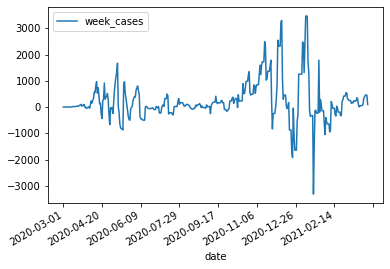

In [107]:
michigan_cases.plot( x = "date", y = "week_cases")
plt.gcf().autofmt_xdate()

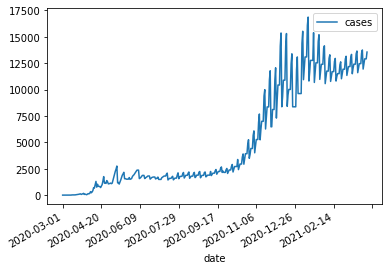

In [108]:
michigan_cases.plot(x="date", y = "cases")
plt.gcf().autofmt_xdate()

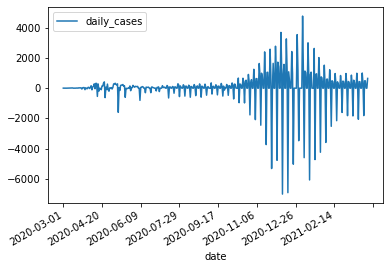

In [109]:
michigan_cases.plot( x = "date", y = "daily_cases")
plt.gcf().autofmt_xdate()

<IPython.core.display.Javascript object>


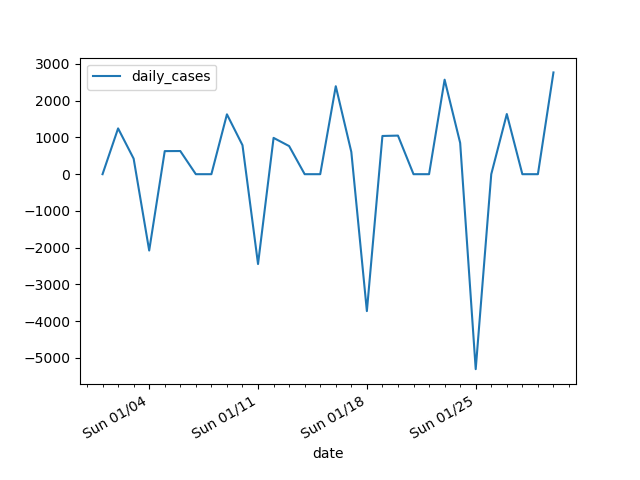

In [136]:
%matplotlib notebook
ax = plt.subplot()
michigan_cases[ (michigan_cases["date"] >= "2020-11-01") & (michigan_cases["date"] < "2020-12-01")]\
    .plot(subplots = True, ax = ax, x = "date", y = "daily_cases")
plt.gcf().autofmt_xdate()
# Major ticks every 6 months.
#fmt_week = mdates.DayLocator(interval=7)
fmt_week = mdates.WeekdayLocator(byweekday = mdates.SU)
ax.xaxis.set_major_locator(fmt_week)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m/%d'))
# Minor ticks every month.
fmt_day = mdates.DayLocator()
ax.xaxis.set_minor_locator(fmt_day)


In [137]:
df_covid_daily.where( col("state")=="Michigan")

30762

In [138]:
df_covid_daily.printSchema()

root
 |-- date: string (nullable = true)
 |-- location_id: long (nullable = true)
 |-- fips: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- deaths: string (nullable = true)
 |-- cases: string (nullable = true)
 |-- deaths_prev: string (nullable = true)
 |-- cases_prev: string (nullable = true)
 |-- daily_deaths: double (nullable = true)
 |-- daily_cases: double (nullable = true)
 |-- days: integer (nullable = true)
 |-- week_deaths: double (nullable = true)
 |-- week_cases: double (nullable = true)



In [139]:
df_covid_daily.where(col("state") == "Michigan")\
    .groupby("location_id", "fips", "county", "state")\
    .sum()

DataFrame[location_id: bigint, fips: string, county: string, state: string, sum(location_id): bigint, sum(daily_deaths): double, sum(daily_cases): double, sum(days): bigint, sum(week_deaths): double, sum(week_cases): double]

In [142]:
df_covid_daily.where((col("state") == "Michigan") & (col("fips").isNull()) ) \
    .select("county", "location_id").distinct().show()

+-------+------------+
| county| location_id|
+-------+------------+
|Unknown|704374636544|
+-------+------------+



In [153]:
michigan_counties = df_covid_daily.where((col("state") == "Michigan") & ( col("fips").isNotNull()))\
    .groupby("date")\
    .sum()\
    .orderBy("date")\
    .toPandas()

In [154]:
michigan_counties

,date,sum(location_id),sum(daily_deaths),sum(daily_cases),sum(days),sum(week_deaths),sum(week_cases)
0,2020-03-10,798863917087,0.0,2.0,868,0.0,2.0
1,2020-03-11,798863917087,0.0,0.0,870,0.0,2.0
2,2020-03-12,2903397892256,0.0,10.0,3052,0.0,12.0
3,2020-03-13,5239860101417,0.0,13.0,4807,0.0,25.0
4,2020-03-14,5652176961846,0.0,8.0,5256,0.0,33.0
...,...,...,...,...,...,...,...
380,2021-03-25,31421980739291,54.0,5891.0,67562,159.0,28855.0
381,2021-03-26,31421980739291,21.0,5988.0,67645,167.0,30579.0
382,2021-03-27,31421980739291,23.0,5026.0,67728,141.0,32279.0
383,2021-03-28,31421980739291,0.0,116.0,67811,141.0,32238.0


<IPython.core.display.Javascript object>


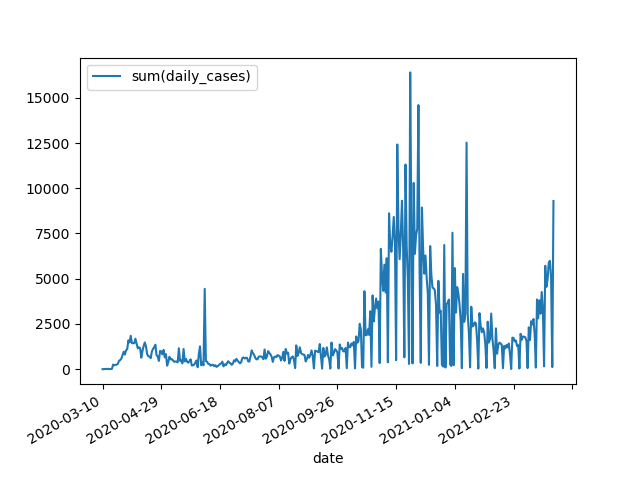

In [163]:
michigan_counties.plot(x = "date", y = "sum(daily_cases)")
plt.gcf().autofmt_xdate()

<IPython.core.display.Javascript object>


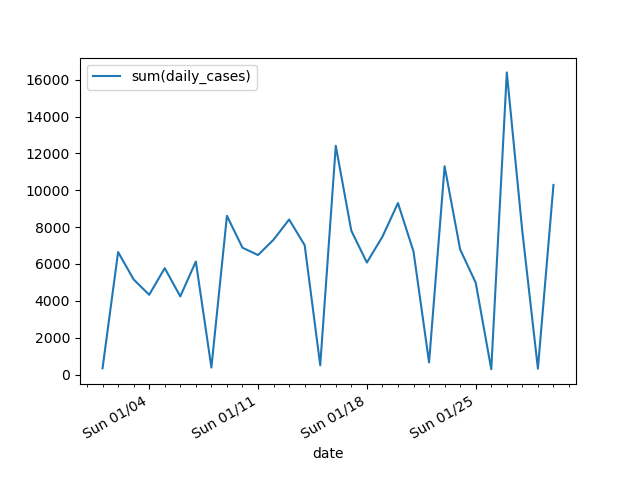

In [161]:
plt.figure()
ax = plt.subplot()
michigan_counties[ (michigan_counties["date"] >= "2020-11-01") & (michigan_counties["date"] < "2020-12-01")]\
    .plot(subplots = True, ax = ax, x = "date", y = "sum(daily_cases)")
plt.gcf().autofmt_xdate()
fmt_week = mdates.WeekdayLocator(byweekday = mdates.SU)
ax.xaxis.set_major_locator(fmt_week)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m/%d'))
# Minor ticks every month.
fmt_day = mdates.DayLocator()
ax.xaxis.set_minor_locator(fmt_day)


In [165]:
all_michigan = df_covid_daily.where(col("state") == "Michigan")\
    .groupBy("date")\
    .sum()\
    .toPandas()


<IPython.core.display.Javascript object>


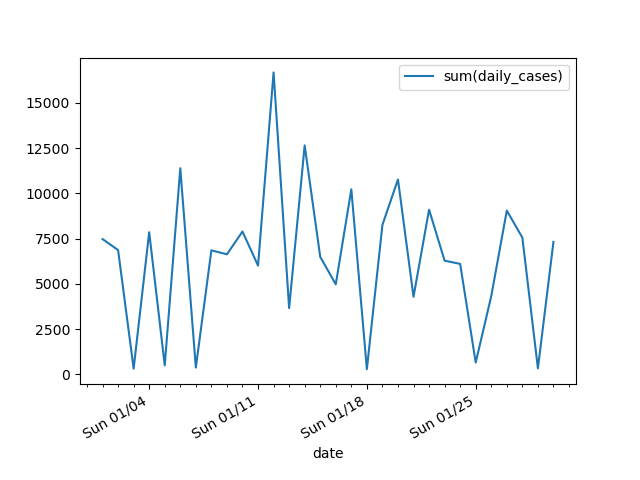

In [167]:
plt.figure()
ax = plt.subplot()

all_michigan[ (all_michigan["date"] >= "2020-11-01") & (all_michigan["date"] < "2020-12-01")]\
    .plot(subplots = True, ax = ax, x = "date", y = "sum(daily_cases)")
plt.gcf().autofmt_xdate()
fmt_week = mdates.WeekdayLocator(byweekday = mdates.SU)
ax.xaxis.set_major_locator(fmt_week)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m/%d'))
# Minor ticks every month.
fmt_day = mdates.DayLocator()
ax.xaxis.set_minor_locator(fmt_day)
